In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [389]:
fileName = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(fileName)

### First look

In [390]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [391]:
df.shape

(5110, 12)

In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Data preprocessing

We want to analyse the features that are good predictory for having a stroke. Thus, "stroke" is the
target variable.

The data consists of both numerical and categorical features. From the data we can see that bmi is
null for certain rows. Also, id is not a feature hence can be dropped.

In [393]:
df = df.drop(columns='id')

In [394]:
target = "stroke"
numerical = list()
categorical = list()
for col in df.columns:
    if col == target:
        continue
    if len(df[col].value_counts()) > 5:
        numerical.append(col)
    else:
        categorical.append(col)

print("Numerical features:", numerical)
print("Categorical features:", categorical)
print("Target:", target)

Numerical features: ['age', 'avg_glucose_level', 'bmi']
Categorical features: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Target: stroke


### Numerical attributes

In [395]:
df[numerical].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


All numerical attributes are of ratio type.

We will replace null bmi values with median and then check of correlation between them to find out
if all the numerical attributes are independent or not.

In [396]:
df['bmi'].fillna(df['bmi'].median(), inplace= True)

In [397]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

                        age  avg_glucose_level       bmi
age                1.000000           0.238171  0.324296
avg_glucose_level  0.238171           1.000000  0.166876
bmi                0.324296           0.166876  1.000000


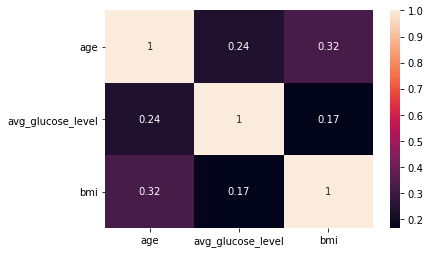

In [398]:
corr_matrix = df[numerical].corr()
print(corr_matrix)
sb.heatmap(corr_matrix, annot=True)
plt.show()

From the correlation matrix we see that numerical features are mostly independent of each other.

Thus, we do not need to perform Principal Component Analysis for numerical features.

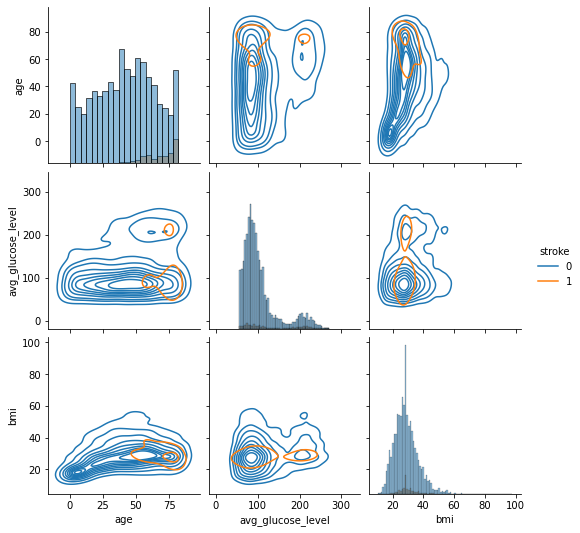

In [399]:
# pairwise scatter plot
input_columns = numerical
input_columns.append(target)
sb.pairplot(df[input_columns], kind="kde", hue=target, diag_kind="hist")
plt.show()

From the pairwise scatter plot we can see that age is a strong predictor of stroke, but the same
cannot be said for avg_glucose_level or bmi.

### Categorical attributes

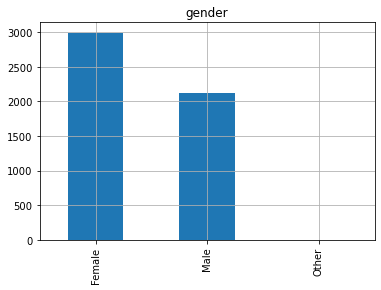

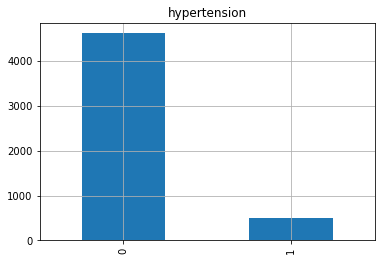

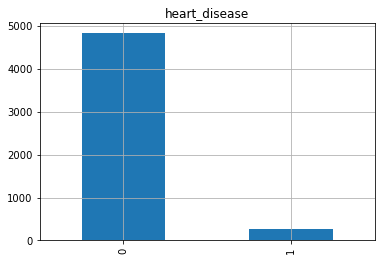

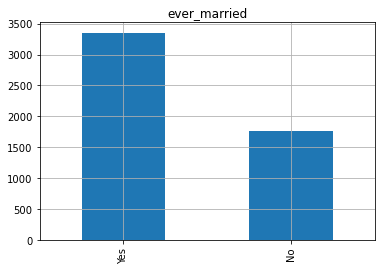

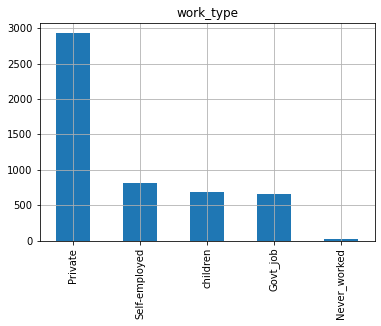

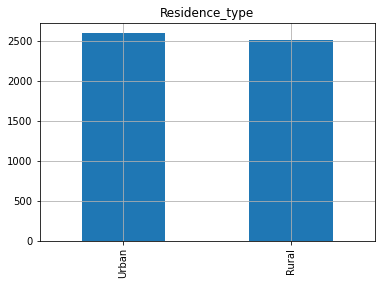

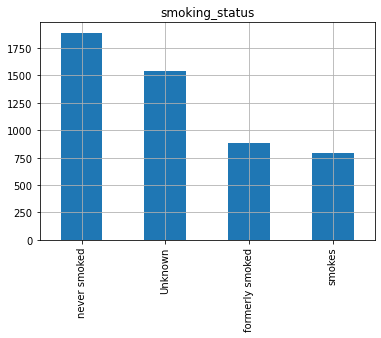

In [400]:
for col in categorical:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.grid()
    plt.show()